In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from circadian.models import DynamicalTrajectory, Skeldon23

In [2]:
data_location = 'data/light_schedules/'
time = np.load(data_location + 'time.npy')
regular_light = np.load(data_location + 'regular_light.npy')
chang14_ebook_first_light = np.load(data_location + 'chang14_ebook_first_light.npy')
chang14_ebook_second_light = np.load(data_location + 'chang14_ebook_second_light.npy')

In [3]:
simulation_features = pd.read_csv("data/chang14_selected_light_sensitivity_parameters/selected_light_sensitivity_parameters_simulation_features.csv", index_col=0)

# Large CBTmin variation filter

In [219]:
cbtmin_std_threshold = 2.0

filtered_simulation_features = pd.DataFrame()

light_schedule_options = ['chang14', 'chang14_high', 'realistic']
light_condition_options = ['early_light', 'late_light']
ebook_order_options = ['ebook_first', 'ebook_second']

for light_schedule in light_schedule_options:
    for light_condition in light_condition_options:
        for ebook_order in ebook_order_options:
            first_day = 12 if ebook_order == 'ebook_first' else 6
            second_day = 6 if ebook_order == 'ebook_first' else 12

            book_cbtmin = simulation_features[(simulation_features['day'] == first_day) & (simulation_features['daily_condition'] == 'Book') &
                                                (simulation_features['simulation_condition'] == f'{light_schedule}_{ebook_order}') &
                                                (simulation_features['light_condition'] == light_condition)]
            ebook_cbtmin = simulation_features[(simulation_features['day'] == second_day) & (simulation_features['daily_condition'] == 'eBook') &
                                                (simulation_features['simulation_condition'] == f'{light_schedule}_{ebook_order}') &
                                                (simulation_features['light_condition'] == light_condition)]
            for i in book_cbtmin.index:
                book_data = book_cbtmin.loc[i]
                ebook_data = ebook_cbtmin.loc[i]

                if np.std(book_data['cbtmin']) <= cbtmin_std_threshold and np.std(ebook_data['cbtmin']) <= cbtmin_std_threshold:
                    to_add = simulation_features[(simulation_features['simulation_condition'] == f'{light_schedule}_{ebook_order}') & 
                                                 (simulation_features['light_condition'] == light_condition)]
                    to_add = to_add.loc[i]
                    filtered_simulation_features = pd.concat([filtered_simulation_features, to_add])

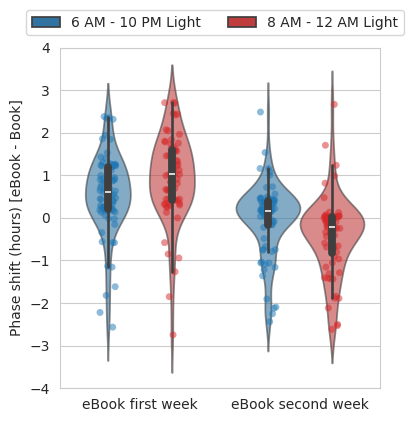

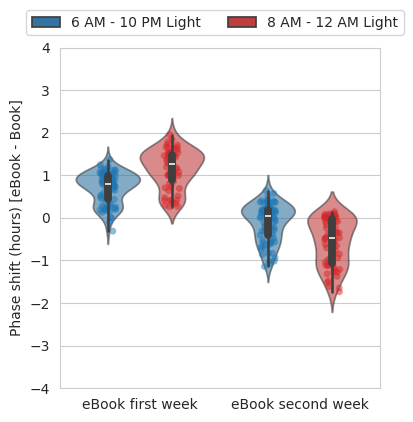

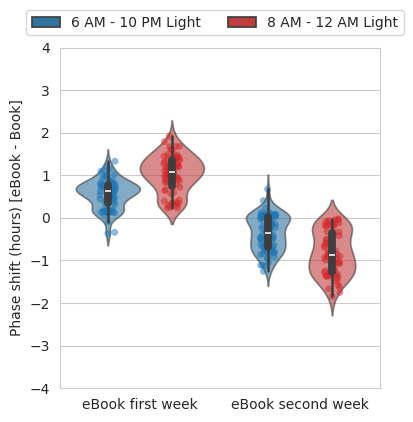

In [224]:
light_condition_options = ['early_light', 'late_light']
light_schedule_options = ['chang14', 'chang14_high', 'realistic']
plot_title = {
    'chang14': 'Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
    'chang14_high': 'Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
    'realistic': 'Chang 14 schedule, indoor light: 500 lux, reading time: 1 hour'
}

for light_schedule in light_schedule_options:
    df = pd.DataFrame()
    for light_condition in light_condition_options:
        selected_parameters = pd.read_csv(f'data/light_sensitivity_parameter_exploration/{light_condition}_selected_light_sensitivity_parameters.csv', index_col=0)
        
        # ebook first
        book_cbtmin = filtered_simulation_features[(filtered_simulation_features['day'] == 12) & (filtered_simulation_features['daily_condition'] == 'Book') &
                                          (filtered_simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                          (filtered_simulation_features['light_condition'] == light_condition)]#[['cbtmin', 'simulation_condition']]
        ebook_cbtmin = filtered_simulation_features[(filtered_simulation_features['day'] == 6) & (filtered_simulation_features['daily_condition'] == 'eBook') &
                                           (filtered_simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                           (filtered_simulation_features['light_condition'] == light_condition)]#[['cbtmin','simulation_condition']]
        shift_first = pd.DataFrame()
        shift_first['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_first['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_first['light_condition'] = light_condition
        shift_first['p'] = selected_parameters['p'].values
        shift_first['k'] = selected_parameters['k'].values
        shift_first['tauc'] = selected_parameters['tauc'].values
        # ebook second
        book_cbtmin = filtered_simulation_features[(filtered_simulation_features['day'] == 6) & (filtered_simulation_features['daily_condition'] == 'Book') &
                                          (filtered_simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') &
                                          (filtered_simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        ebook_cbtmin = filtered_simulation_features[(filtered_simulation_features['day'] == 12) & (filtered_simulation_features['daily_condition'] == 'eBook') &
                                           (filtered_simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') & 
                                           (filtered_simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        shift_second = pd.DataFrame()
        shift_second['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_second['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_second['light_condition'] = light_condition
        shift_second['p'] = selected_parameters['p'].values
        shift_second['k'] = selected_parameters['k'].values
        shift_second['tauc'] = selected_parameters['tauc'].values

        # filter out diff larger than 5
        shift_first = shift_first[np.abs(shift_first['diff']) < 3]
        shift_second = shift_second[np.abs(shift_second['diff']) < 3]

        df = pd.concat([df, shift_first, shift_second])

    # violin plot
    palette = {
        'early_light': 'tab:blue',
        'late_light': 'tab:red'
    }
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.violinplot(x='simulation_condition', y='diff', hue='light_condition', data=df, ax=ax,
                   palette=palette)

    for violin  in ax.collections[::]:
        violin.set_alpha(0.6)

    sns.stripplot(x='simulation_condition', y='diff', hue='light_condition', data=df, ax=ax, dodge=True, jitter=True,
                  alpha=0.5, zorder=1, legend=False, palette=palette)
    ax.set_ylabel('Phase shift (hours) [eBook - Book]')
    ax.set_xticks(range(len(df['simulation_condition'].unique())))
    ax.set_xticklabels(['eBook first week', 'eBook second week'])
    handles, labels = ax.get_legend_handles_labels()
    labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
    fig.legend(handles, labels, bbox_to_anchor=(0.55, 1.06), loc='upper center', ncol=2)
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylim(-4, 4)

    plt.tight_layout()
    plt.show()

# Phase shift

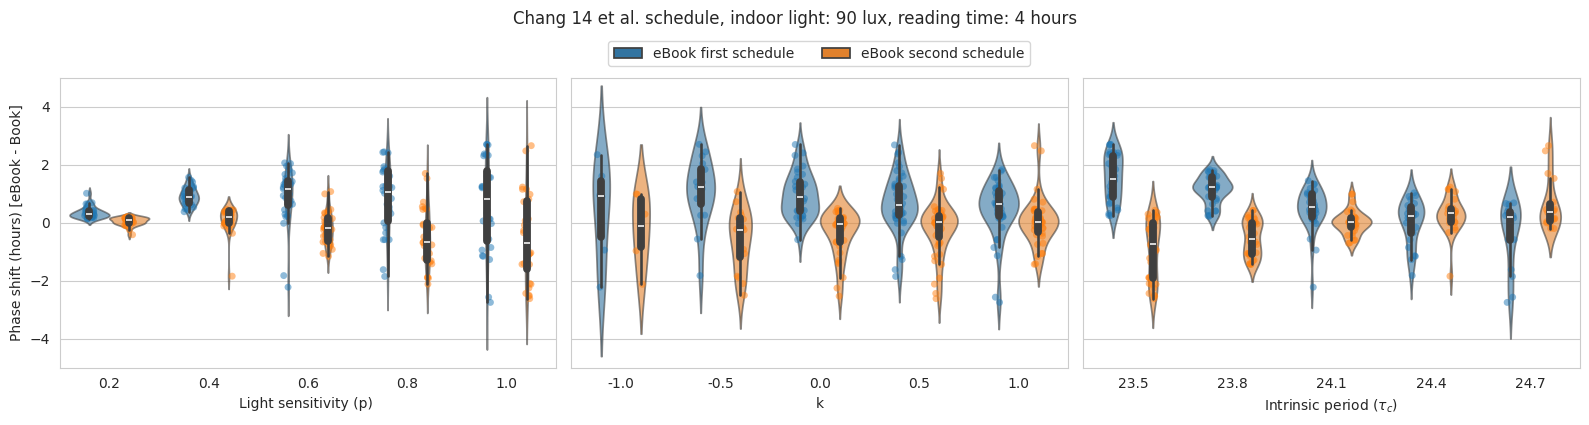

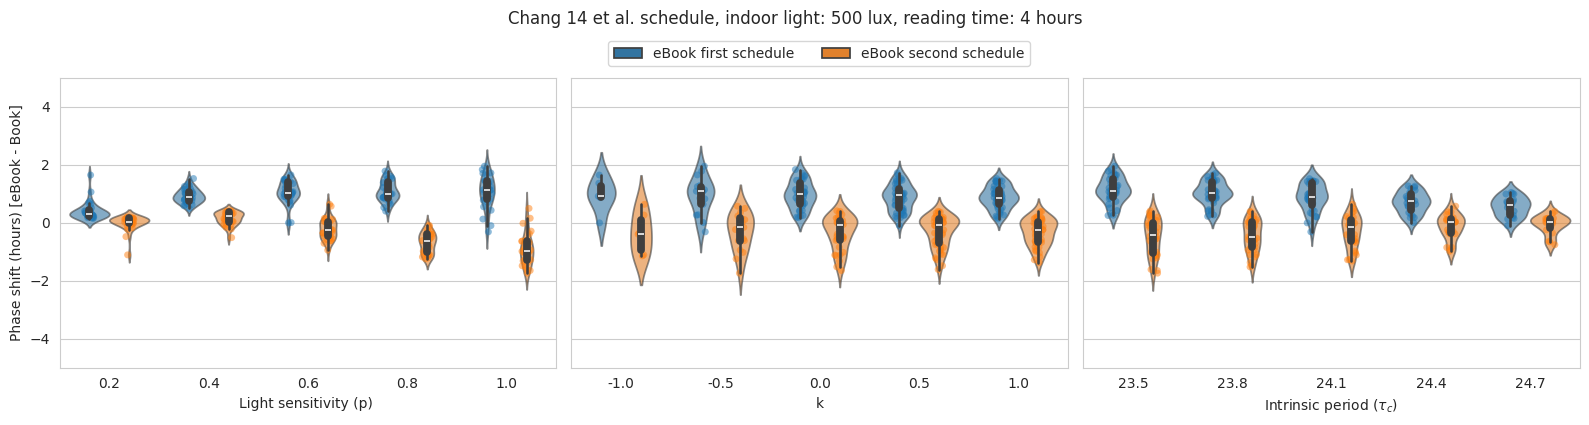

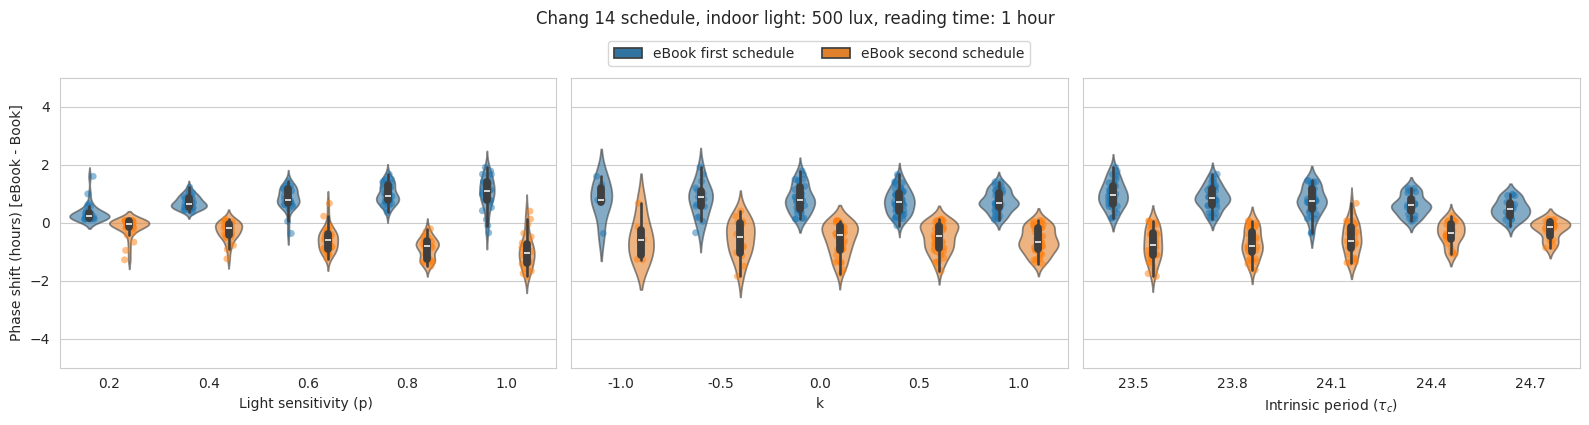

In [136]:
light_condition_options = ['early_light', 'late_light']
light_schedule_options = ['chang14', 'chang14_high', 'realistic']
plot_title = {
    'chang14': 'Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
    'chang14_high': 'Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
    'realistic': 'Chang 14 schedule, indoor light: 500 lux, reading time: 1 hour'
}

for light_schedule in light_schedule_options:
    df = pd.DataFrame()
    for light_condition in light_condition_options:
        selected_parameters = pd.read_csv(f'data/light_sensitivity_parameter_exploration/{light_condition}_selected_light_sensitivity_parameters.csv', index_col=0)
        
        # ebook first
        book_cbtmin = simulation_features[(simulation_features['day'] == 12) & (simulation_features['daily_condition'] == 'Book') &
                                          (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                          (simulation_features['light_condition'] == light_condition)]#[['cbtmin', 'simulation_condition']]
        ebook_cbtmin = simulation_features[(simulation_features['day'] == 6) & (simulation_features['daily_condition'] == 'eBook') &
                                           (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                           (simulation_features['light_condition'] == light_condition)]#[['cbtmin','simulation_condition']]
        shift_first = pd.DataFrame()
        shift_first['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_first['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_first['light_condition'] = light_condition
        shift_first['p'] = selected_parameters['p'].values
        shift_first['k'] = selected_parameters['k'].values
        shift_first['tauc'] = selected_parameters['tauc'].values
        # ebook second
        book_cbtmin = simulation_features[(simulation_features['day'] == 6) & (simulation_features['daily_condition'] == 'Book') &
                                          (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') &
                                          (simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        ebook_cbtmin = simulation_features[(simulation_features['day'] == 12) & (simulation_features['daily_condition'] == 'eBook') &
                                           (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') & 
                                           (simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        shift_second = pd.DataFrame()
        shift_second['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_second['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_second['light_condition'] = light_condition
        shift_second['p'] = selected_parameters['p'].values
        shift_second['k'] = selected_parameters['k'].values
        shift_second['tauc'] = selected_parameters['tauc'].values

        # filter out diff larger than 5
        shift_first = shift_first[np.abs(shift_first['diff']) < 3]
        shift_second = shift_second[np.abs(shift_second['diff']) < 3]

        df = pd.concat([df, shift_first, shift_second])

    # violin plot
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
    sns.violinplot(x='p', y='diff', hue='simulation_condition', data=df, ax=ax[0])
    sns.violinplot(x='k', y='diff', hue='simulation_condition', data=df, ax=ax[1], legend=False)
    sns.violinplot(x='tauc', y='diff', hue='simulation_condition', data=df, ax=ax[2], legend=False)

    for ax_i in ax:
        for violin  in ax_i.collections[::]:
            violin.set_alpha(0.6)

    sns.stripplot(x='p', y='diff', hue='simulation_condition', data=df, ax=ax[0], dodge=True, jitter=True,
                alpha=0.5, zorder=1, legend=False)
    sns.stripplot(x='k', y='diff', hue='simulation_condition', data=df, ax=ax[1], dodge=True, jitter=True,
                    alpha=0.5, zorder=1, legend=False)
    sns.stripplot(x='tauc', y='diff', hue='simulation_condition', data=df, ax=ax[2], dodge=True, jitter=True,
                    alpha=0.5, zorder=1, legend=False)
    # adjust legend position
    handles, labels = ax[0].get_legend_handles_labels()
    labels = ['eBook first schedule', 'eBook second schedule']
    fig.legend(handles, labels, bbox_to_anchor=(0.515, 0.99), loc='upper center', ncol=2)
    # remove legend from each subplot
    ax[0].get_legend().remove()
    # ax[0] fix x tick labels
    ax[0].set_xticks(range(len(df['p'].unique())))
    ax[0].set_xticklabels([f'{p:.1f}' for p in df['p'].unique()])

    ax[0].set_ylim(-5, 5)
    ax[0].set_ylabel('Phase shift (hours) [eBook - Book]')
    ax[0].set_xlabel('Light sensitivity (p) ')
    ax[2].set_xlabel(r'Intrinsic period ($\tau_{c}$) ')
    fig.suptitle(plot_title[light_schedule], y=1.05)
    plt.tight_layout()
    plt.show()

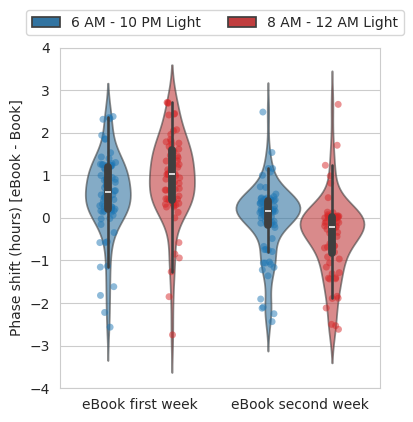

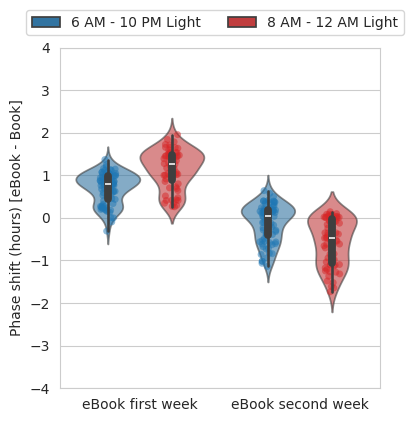

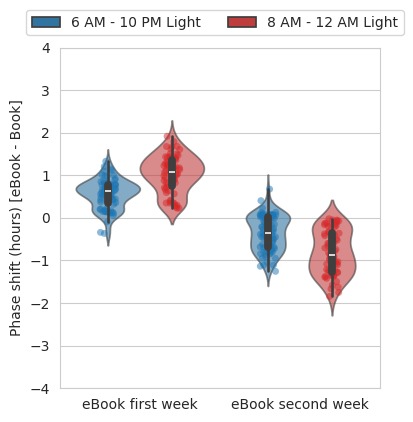

In [ ]:
light_condition_options = ['early_light', 'late_light']
light_schedule_options = ['chang14', 'chang14_high', 'realistic']
plot_title = {
    'chang14': 'Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
    'chang14_high': 'Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
    'realistic': 'Chang 14 schedule, indoor light: 500 lux, reading time: 1 hour'
}

for light_schedule in light_schedule_options:
    df = pd.DataFrame()
    for light_condition in light_condition_options:
        selected_parameters = pd.read_csv(f'data/light_sensitivity_parameter_exploration/{light_condition}_selected_light_sensitivity_parameters.csv', index_col=0)
        
        # ebook first
        book_cbtmin = simulation_features[(simulation_features['day'] == 12) & (simulation_features['daily_condition'] == 'Book') &
                                          (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                          (simulation_features['light_condition'] == light_condition)]#[['cbtmin', 'simulation_condition']]
        ebook_cbtmin = simulation_features[(simulation_features['day'] == 6) & (simulation_features['daily_condition'] == 'eBook') &
                                           (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_first') &
                                           (simulation_features['light_condition'] == light_condition)]#[['cbtmin','simulation_condition']]
        shift_first = pd.DataFrame()
        shift_first['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_first['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_first['light_condition'] = light_condition
        shift_first['p'] = selected_parameters['p'].values
        shift_first['k'] = selected_parameters['k'].values
        shift_first['tauc'] = selected_parameters['tauc'].values
        # ebook second
        book_cbtmin = simulation_features[(simulation_features['day'] == 6) & (simulation_features['daily_condition'] == 'Book') &
                                          (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') &
                                          (simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        ebook_cbtmin = simulation_features[(simulation_features['day'] == 12) & (simulation_features['daily_condition'] == 'eBook') &
                                           (simulation_features['simulation_condition'] == f'{light_schedule}_ebook_second') & 
                                           (simulation_features['light_condition'] == light_condition)][['cbtmin', 'simulation_condition']]
        shift_second = pd.DataFrame()
        shift_second['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
        shift_second['simulation_condition'] = ebook_cbtmin['simulation_condition']
        shift_second['light_condition'] = light_condition
        shift_second['p'] = selected_parameters['p'].values
        shift_second['k'] = selected_parameters['k'].values
        shift_second['tauc'] = selected_parameters['tauc'].values

        # filter out diff larger than 5
        shift_first = shift_first[np.abs(shift_first['diff']) < 3]
        shift_second = shift_second[np.abs(shift_second['diff']) < 3]

        df = pd.concat([df, shift_first, shift_second])

    # violin plot
    palette = {
        'early_light': 'tab:blue',
        'late_light': 'tab:red'
    }
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.violinplot(x='simulation_condition', y='diff', hue='light_condition', data=df, ax=ax,
                   palette=palette)

    for violin  in ax.collections[::]:
        violin.set_alpha(0.6)

    sns.stripplot(x='simulation_condition', y='diff', hue='light_condition', data=df, ax=ax, dodge=True, jitter=True,
                  alpha=0.5, zorder=1, legend=False, palette=palette)
    ax.set_ylabel('Phase shift (hours) [eBook - Book]')
    ax.set_xticks(range(len(df['simulation_condition'].unique())))
    ax.set_xticklabels(['eBook first week', 'eBook second week'])
    handles, labels = ax.get_legend_handles_labels()
    labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
    fig.legend(handles, labels, bbox_to_anchor=(0.55, 1.06), loc='upper center', ncol=2)
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylim(-4, 4)

    plt.tight_layout()
    plt.show()

# Mean CBTmin evolution

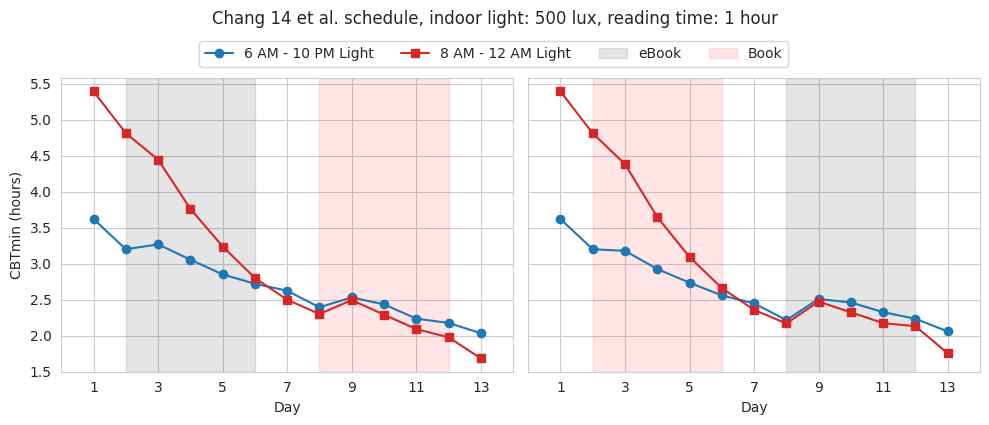

In [231]:

light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    # ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_first') & \
    #                                   (simulation_features['light_condition'] == light_condition)]
    # ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_second') & \
    #                                    (simulation_features['light_condition'] == light_condition)]

    ebook_first = filtered_simulation_features[(filtered_simulation_features['simulation_condition'] == 'realistic_ebook_first') & \
                                      (filtered_simulation_features['light_condition'] == light_condition)]
    ebook_second = filtered_simulation_features[(filtered_simulation_features['simulation_condition'] == 'realistic_ebook_second') & \
                                       (filtered_simulation_features['light_condition'] == light_condition)]

    days = np.arange(1, 14)
    '''
    keep_idx_first = []
    keep_idx_second = []
    # add individual cbtmin curves in light gray
    for i in np.unique(ebook_first.index):
        ebook_first_i = ebook_first.loc[i]
        ebook_second_i = ebook_second.loc[i]
        if ebook_first_i['cbtmin'].std() <= 2:
            keep_idx_first.append(i)
            # if light_condition == 'early_light':
            #     axs[0].plot(ebook_first_i['day'], ebook_first_i['cbtmin'], color='tab:blue', alpha=0.1)
            # else:
            #     axs[0].plot(ebook_first_i['day'], ebook_first_i['cbtmin'], color='tab:red', alpha=0.1)
        if ebook_second_i['cbtmin'].std() <= 2:
            keep_idx_second.append(i)
            # if light_condition == 'early_light':
            #     axs[1].plot(ebook_second_i['day'], ebook_second_i['cbtmin'], color='tab:blue', alpha=0.1)
            # else:
            #     axs[1].plot(ebook_second_i['day'], ebook_second_i['cbtmin'], color='tab:red', alpha=0.1)
        
        # if light_condition == 'late_light':
        #     axs[0].plot(ebook_first_i['day'], ebook_first_i['cbtmin'], color='tab:blue', alpha=0.1)
        # axs[0].plot(ebook_first_i['day'], ebook_first_i['cbtmin'], color='lightgray', alpha=0.5)
        # axs[1].plot(ebook_second_i['day'], ebook_second_i['cbtmin'], color='lightgray', alpha=0.5)
    
    # filter out cbtmin with std larger than 2
    ebook_first = ebook_first.loc[keep_idx_first]
    ebook_second = ebook_second.loc[keep_idx_second]
    '''
    ebook_first_cbtmin = ebook_first.groupby('day')['cbtmin'].median() # + offset[idx]
    ebook_second_cbtmin = ebook_second.groupby('day')['cbtmin'].median() # + offset[idx]


    axs[0].plot(days, ebook_first_cbtmin,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_cbtmin,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    # axs[0].set_yticks([22, 23, 24, 25])
    # axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('CBTmin (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
             y=1.05)

plt.tight_layout()

# plt.savefig('figures/chang14_low_indoor_light_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

In [166]:
np.unique(ebook_first.index)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

# Sleep latency histogram comparison

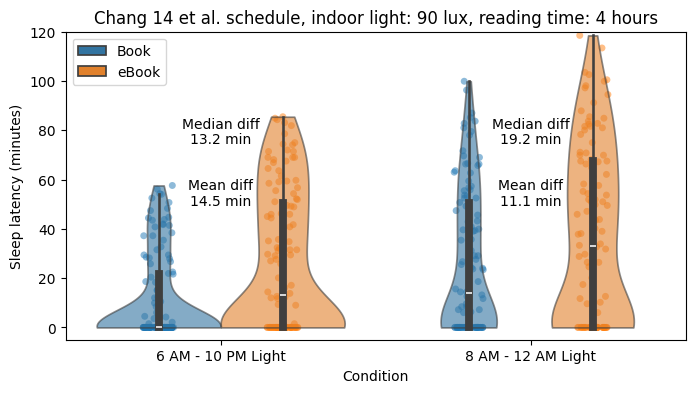

In [97]:
# Sleep latency at last condition day for Chang 14 schedule
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)
# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])

median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_low_indoor_light_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

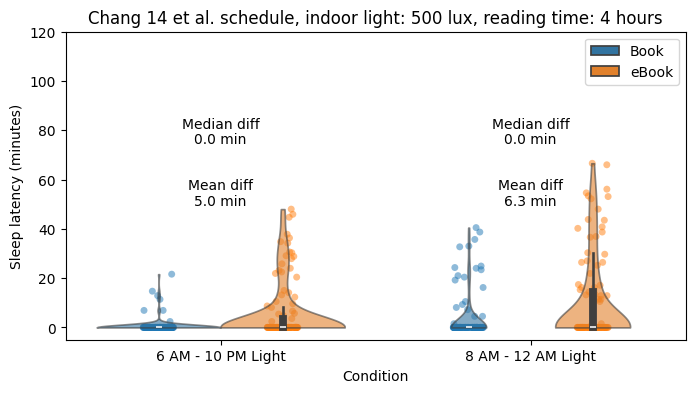

In [98]:
# Sleep latency at last condition day for Chang 14 schedule with high indoor light
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_high_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_high_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_high_indoor_light_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

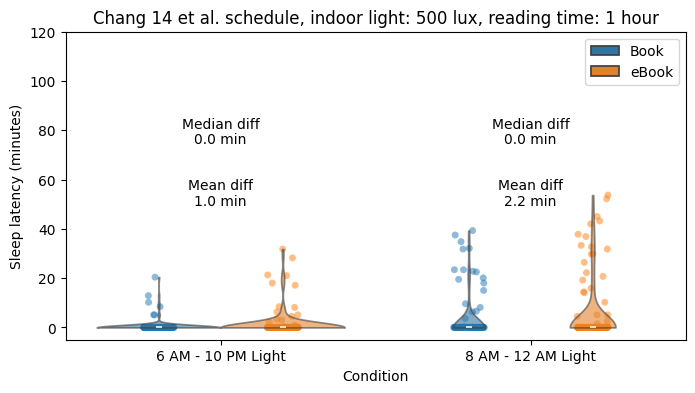

In [99]:
# Sleep latency at last condition day for Chang 14 schedule with realistic reading time
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'realistic_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'realistic_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_realistic_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

# Sleep duration

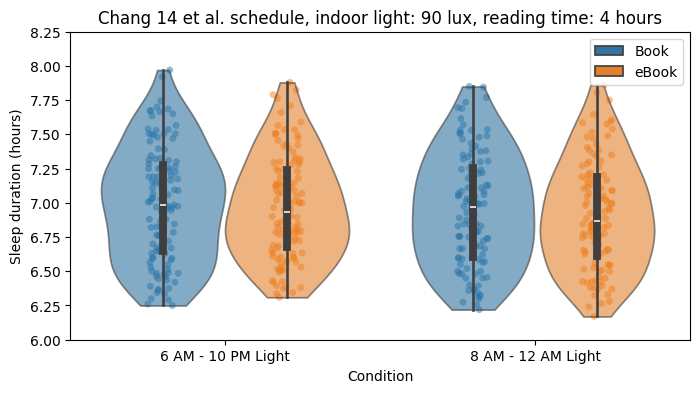

In [100]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_low_indoor_light_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

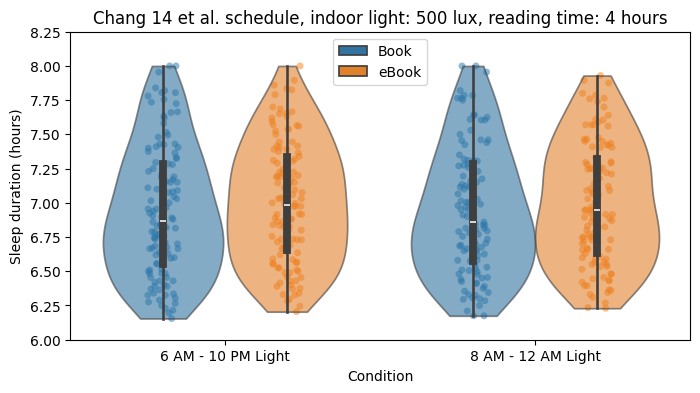

In [101]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_high_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_high_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_high_indoor_light_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

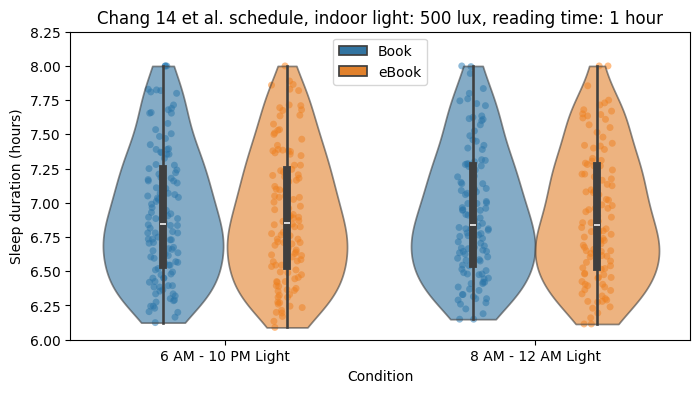

In [102]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'realistic_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'realistic_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_realistic_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

# Mean sleep onset evolution

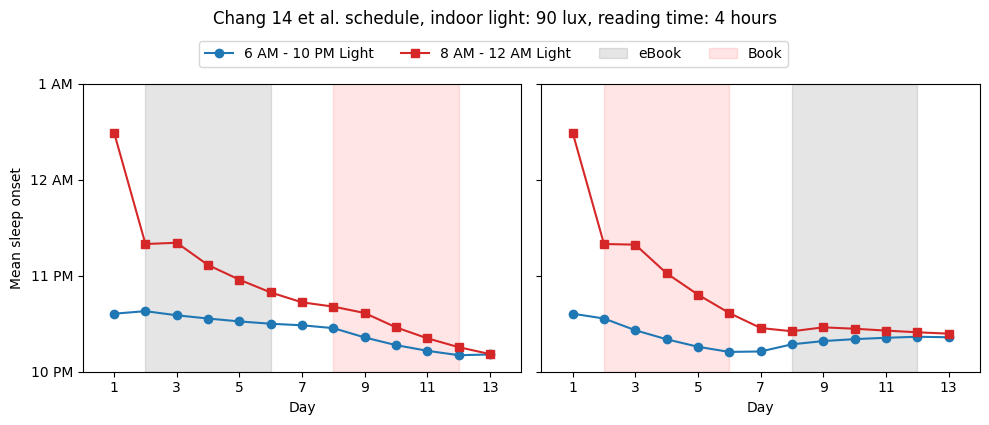

In [103]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_low_indoor_light_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

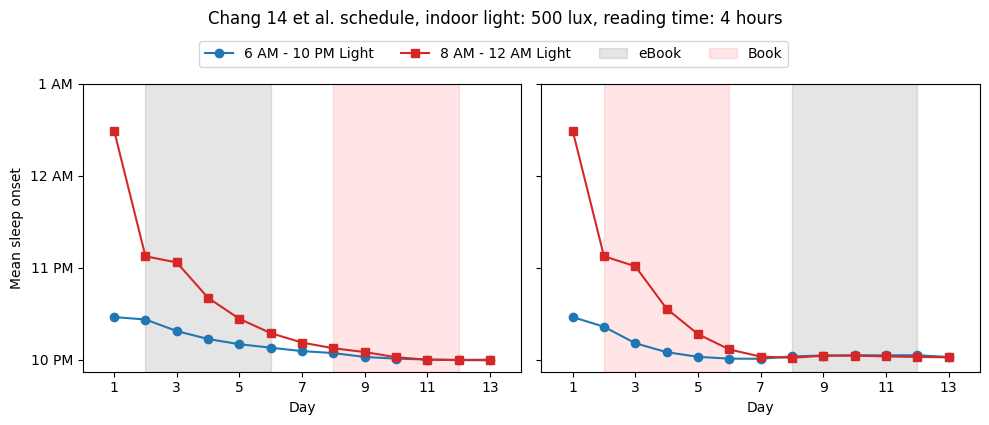

In [104]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_high_indoor_light_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

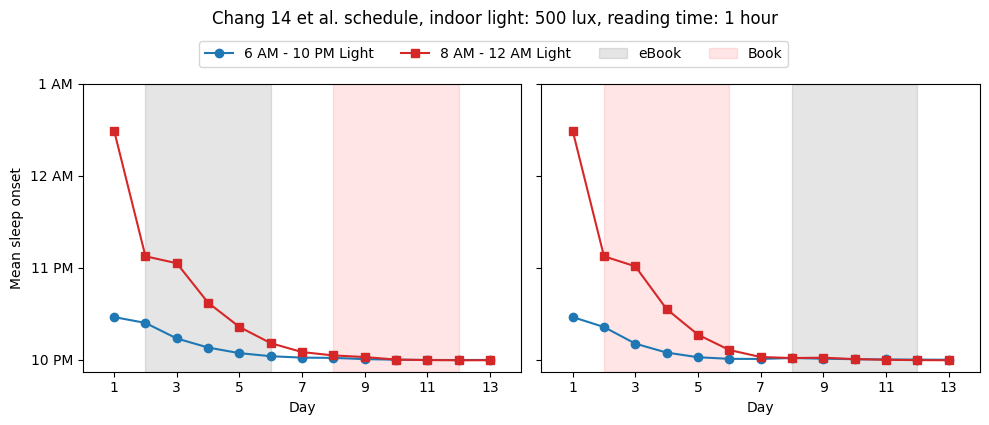

In [105]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_realistic_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

# Mean sleep duration evolution

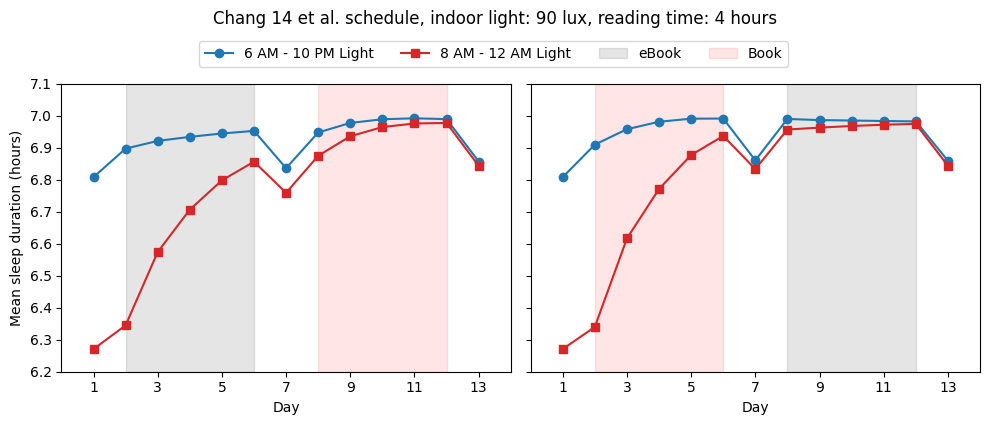

In [112]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
             y=1.05)

axs[0].set_ylim(6.2, 7.1)

plt.tight_layout()

plt.savefig('figures/chang14_low_indoor_light_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

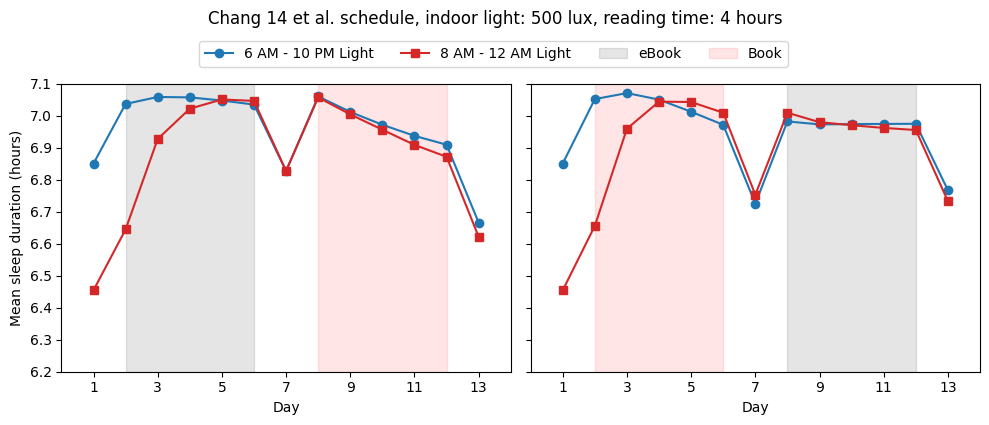

In [113]:

light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
             y=1.05)
axs[0].set_ylim(6.2, 7.1)

plt.tight_layout()

plt.savefig('figures/chang14_high_indoor_light_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

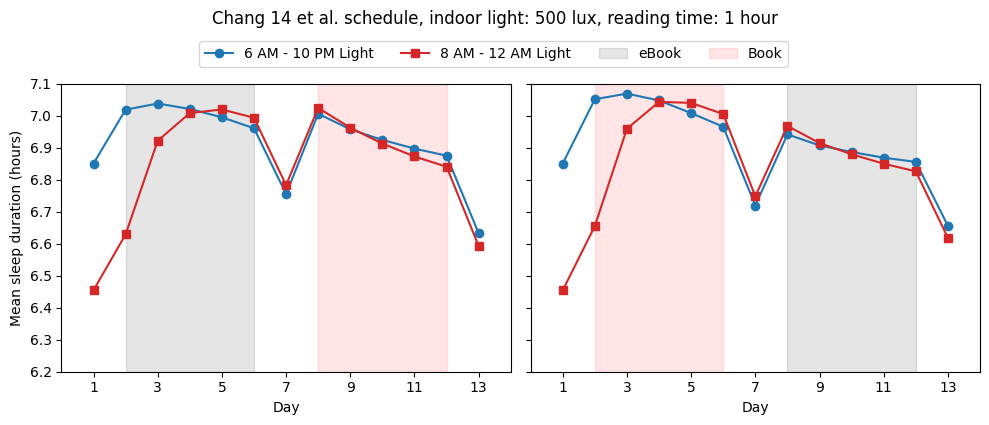

In [114]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
             y=1.05)

axs[0].set_ylim(6.2, 7.1)
plt.tight_layout()

plt.savefig('figures/chang14_realistic_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()